In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import DataReader as pdr
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

## Data

#### Returns from second_backtest

In [2]:
rets = pd.read_csv("files/rets.csv", parse_dates=["date"], index_col="date")
rets.index = rets.index.to_period("M")

#### Fama-French factors

In [3]:
ff = pdr("F-F_Research_Data_5_Factors_2x3", "famafrench", start=2005)[0]/100

#### Market and 130/30 returns

In [4]:
rets["mkt"] = ff["Mkt-RF"] + ff["RF"]
rets["ls"] = 1.3*rets["best"] - 0.3*rets["worst"]
rets["rf"] = ff["RF"]

## Raw Returns

#### Accumulations

<AxesSubplot: xlabel='date'>

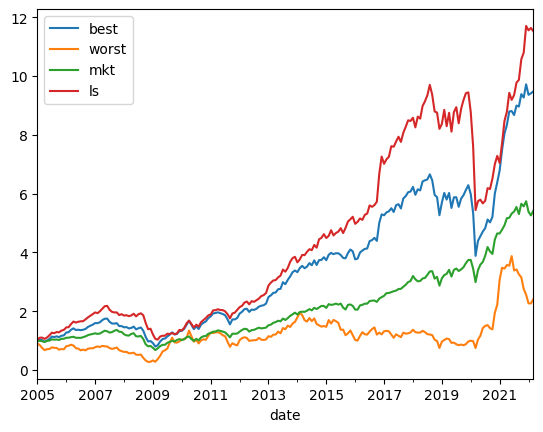

In [5]:
(1+rets[["best", "worst", "mkt", "ls"]]).cumprod().plot()

#### Means and risks

In [6]:
print(12*rets[["best", "worst", "mkt", "ls"]].mean())
print(np.sqrt(12)*rets[["best", "worst", "mkt", "ls"]].std())

best     0.148635
worst    0.115483
mkt      0.109803
ls       0.158581
dtype: float64
best     0.184892
worst    0.369055
mkt      0.150797
ls       0.175752
dtype: float64


#### Excess returns and Sharpe ratios

In [7]:
xrets = rets[["best", "worst", "mkt", "ls"]].subtract(rets.rf, axis=0)
sharpes = np.sqrt(12)*xrets.mean()/xrets.std()
sharpes

best     0.740514
worst    0.281762
mkt      0.651299
ls       0.836286
dtype: float64

#### 130/30 drawdowns

Text(0, 0.5, 'Drawdown')

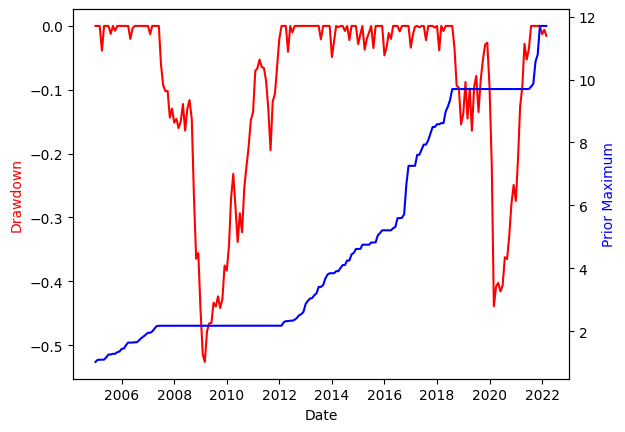

In [9]:
ls = (1+rets.ls).cumprod()
lsmax = ls.expanding().max()

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.plot(rets.index.to_timestamp(), lsmax, 'b-')
ax1.plot(rets.index.to_timestamp(), ls/lsmax - 1, 'r-')

ax1.set_xlabel('Date')
ax2.set_ylabel('Prior Maximum', color='b')
ax1.set_ylabel('Drawdown', color='r')

## Market benchmark

#### Regressions on excess market return

In [10]:
tables = []
coefs = []
actives = []

for string in ["best~mkt", "worst~mkt", "ls~mkt"]:
    result = smf.ols(string, data=xrets).fit()
    tables.append(result.summary().tables[1])
    coefs.append(result.params)
    actives.append(result.params["Intercept"] + result.resid)


#### Regression tables

In [11]:
for table in tables:
    print(table)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0027      0.002      1.436      0.152      -0.001       0.006
mkt            1.0658      0.042     25.161      0.000       0.982       1.149
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0055      0.005     -1.018      0.310      -0.016       0.005
mkt            1.7235      0.121     14.231      0.000       1.485       1.962
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0051      0.002      2.142      0.033       0.000       0.010
mkt            0.8685      0.054     16.031      0.000       0.762       0.975


#### Active returns and risks

In [12]:
actives = [pd.Series(x, index=xrets.index) for x in actives]
actives = pd.concat(actives, axis=1)
actives.columns = ["best", "worst", "ls"]
np.sqrt(12) * actives.std()


best     0.091713
worst    0.262212
ls       0.117303
dtype: float64

#### Information ratios

In [13]:
info_ratios = np.sqrt(12)*actives.mean()/actives.std()
info_ratios

best     0.352723
worst   -0.250077
ls       0.526210
dtype: float64

#### 130/30 breakdown into market and active returns

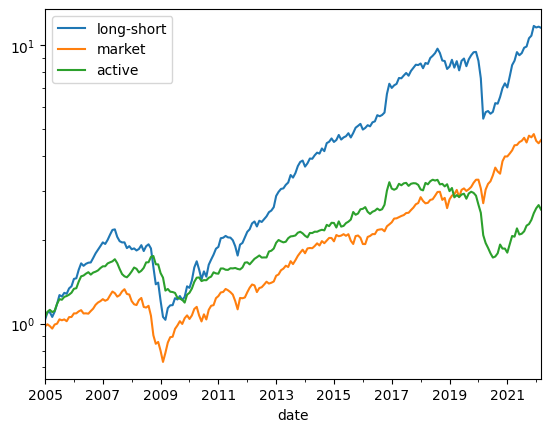

In [14]:
logy = True

beta = coefs[-1]["mkt"]

(1+rets.ls).cumprod().plot(label="long-short", logy=logy)
(1+ rets.rf + beta*xrets.mkt).cumprod().plot(label="market", logy=logy)
(1+actives.ls).cumprod().plot(label="active", logy=logy)
plt.legend()

## Fama-French Benchmark

#### Fama-French factors

In [15]:
xrets[["smb", "hml", "rmw", "cma"]] = ff[["SMB", "HML", "RMW", "CMA"]]

#### Fama-French regressions

In [16]:
tables = []
coefs = []
actives = []

strings = [x+"~mkt+smb+hml+rmw+cma" for x in ["best", "worst", "ls"]]
for string in strings:
    result = smf.ols(string, data=xrets).fit()
    tables.append(result.summary().tables[1])
    coefs.append(result.params)
    actives.append(result.params["Intercept"] + result.resid)

#### Regression tables

In [17]:
for table in tables:
    print(table)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0042      0.001      3.839      0.000       0.002       0.006
mkt            0.8540      0.027     31.335      0.000       0.800       0.908
smb            0.6970      0.049     14.341      0.000       0.601       0.793
hml            0.4047      0.043      9.330      0.000       0.319       0.490
rmw            0.1512      0.064      2.365      0.019       0.025       0.277
cma           -0.0801      0.078     -1.032      0.303      -0.233       0.073
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0006      0.005      0.137      0.891      -0.008       0.010
mkt            1.3727      0.114     12.013      0.000       1.147       1.598
smb            1.2374      0.204      6.072      0.0

#### Active returns and risks

In [18]:
actives = [pd.Series(x, index=xrets.index) for x in actives]
actives = pd.concat(actives, axis=1)
actives.columns = ["best", "worst", "ls"]
np.sqrt(12) * actives.std()

best     0.051483
worst    0.215859
ls       0.083596
dtype: float64

#### Information ratios

In [19]:

info_ratios = np.sqrt(12)*actives.mean()/actives.std()
info_ratios

best     0.985120
worst    0.035102
ls       0.761497
dtype: float64

#### 130/30 attribution analysis

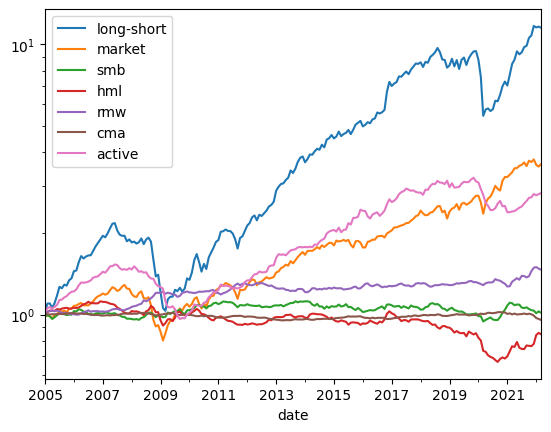

In [20]:
logy = True

betas = coefs[-1]

(1+rets.ls).cumprod().plot(label="long-short", logy=logy)
(1 + rets.rf + betas["mkt"]*xrets.mkt).cumprod().plot(label="market", logy=logy)
(1 + betas["smb"]*xrets.smb).cumprod().plot(label="smb", logy=logy)
(1 + betas["hml"]*xrets.hml).cumprod().plot(label="hml", logy=logy)
(1 + betas["rmw"]*xrets.rmw).cumprod().plot(label="rmw", logy=logy)
(1 + betas["cma"]*xrets.cma).cumprod().plot(label="cma", logy=logy)
(1+actives.ls).cumprod().plot(label="active", logy=logy)
plt.legend()

## Investing in SPY

In [ ]:
!pip install yfinance

In [21]:
import yfinance as yf

spy = yf.download('spy', start='2004-01-01', progress=False)['Adj Close']
spy = spy.resample('M').last()
spy = spy.pct_change().dropna()
spy.index = spy.index.to_period('M')

C:\Users\kerry\AppData\Local\Temp\ipykernel_27280\711389262.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  spy.index = spy.index.to_period('M')


In [22]:
rets["spy"] = spy
rets["ls_spy"] = 0.8*rets.spy + 0.5*rets.best - 0.3*rets.worst